In [5]:
%%capture --no-stderr
%pip install -U langchain-nomic langchain_community tiktoken langchainhub langchain langgraph tavily-python langchain-text-splitters 

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-openai 0.0.5 requires langchain-core<0.2,>=0.1.16, but you have langchain-core 0.2.20 which is incompatible.
langchain-openai 0.0.5 requires tiktoken<0.6.0,>=0.5.2, but you have tiktoken 0.7.0 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [76]:
%pip install -U fuzzywuzzy

  Using cached fuzzywuzzy-0.18.0-py2.py3-none-any.whl.metadata (4.9 kB)
Using cached fuzzywuzzy-0.18.0-py2.py3-none-any.whl (18 kB)

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Tracing (optional)

In [5]:
import os
import requests
import re
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import time

### LLM
local_llm = "llama3.1"

In [6]:
import praw
from collections import Counter

# Replace with your Reddit app credentials
CLIENT_ID = 'Q1q19TyBK8h519ZjBEXjUA'
CLIENT_SECRET = 'CHulvUzsOoddZl5PGf30b5bigw8U-A'
USER_AGENT = 'test'  # You can use any descriptive user agent

# Initialize PRAW with credentials
reddit = praw.Reddit(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    user_agent=USER_AGENT
)


In [31]:
## get subreddits

import pandas as pd
def search_subreddits(query, limit_per_word=5):
    words = query.split(',')
    all_subreddits = []
    
    for word in words:
        try:
            subreddits = reddit.subreddits.search(word, limit=limit_per_word)
            all_subreddits.extend([subreddit.display_name for subreddit in subreddits])
        except Exception as e:
            print(f"Error searching subreddits with query '{word}': {e}")

    return list(set(all_subreddits))


#query_text = "email marketing, coldemail, business leads, marketing "  # Replace with your query text
#subreddits = search_subreddits(query_text)



In [67]:
## get comments

import pandas as pd
def get_top_posts(subreddit_name, limit=3):
    try:
        subreddit = reddit.subreddit(subreddit_name)
        # Check if the subreddit exists by attempting to access its posts
        if subreddit.display_name != subreddit_name:
            raise Exception(f"Subreddit {subreddit_name} does not exist.")
        top_posts = subreddit.top(limit=limit)
        return list(top_posts)  # Convert to list
    except Exception as e:
        print(f"Error fetching top posts from {subreddit_name}: {e}")
        return []

def get_comments_from_post(post):
    try:
        post.comments.replace_more(limit=100)
        comments = [comment.body for comment in post.comments.list()]
        return comments
    except Exception as e:
        print(f"Error fetching comments from post {post.id}: {e}")
        return []

def scrape_reddit_comments(subreddits):
    all_comments = []
    failed_subreddits = []
    
    for subreddit_name in subreddits:
        print(f"Scraping subreddit: {subreddit_name}")
        top_posts = get_top_posts(subreddit_name)
        if not top_posts:  # Skip if no posts were retrieved
            failed_subreddits.append(subreddit_name)
            continue
        for post in top_posts:
            comments = get_comments_from_post(post)
            sub_comments= comments[:100]
            all_comments.extend(sub_comments)
    
    if failed_subreddits:
        print(f"Failed to retrieve data from these subreddits: {', '.join(failed_subreddits)}")
    
    return all_comments

def reddit_comments(sub_reddits):
    output_file=f"{sub_reddits}_comments.csv"
    subreddits = sub_reddits.split(',')
    subreddits = [sub.strip() for sub in subreddits]
    
    comments = scrape_reddit_comments(subreddits)
    print(comments)
    print(f"Total comments scraped: {len(comments)}")
    
    #if comments:
    #    df = pd.DataFrame(comments, columns=['Comment'])
    #    df.to_csv(output_file, index=False)
    #    print(f"Comments for {subreddits} scraped and saved to {output_file}")
    #else:
    #    print("No comments scraped from {subreddits}.")
    return comments



In [8]:
sub_reddits = "SaaS_Email_Marketing, ColdEmailAndSales"  # Provide subreddits here
    
comments= reddit_comments(sub_reddits)

Scraping subreddit: SaaS_Email_Marketing
Scraping subreddit: ColdEmailAndSales
['Looks like a cold email strategy so the problem is not content, it’s because unwanted emails. PS Remember there is no such thing as long or short content, only boring content.', '[deleted]', 'exactly!', '+1', 'How can these templates enhance customer service efficiency?', 'Save time and improve service quality with ready-made email templates.', 'Experiment with using templates to ensure consistent and accurate responses.', "I would say, for start-ups who don't have templates already saved on hand or part of their workflows, snippets, etc. This is a great jump start to ensure you have some verbiage ready to go for those first customers when they read out. Definitely basic, but there are a ton of companies starting up each day. \n\nMissing a CTA on the blog though, even just sign up for the newsletter!", '[removed]', 'Yet another new learning. Thanks for sharing the knowledge and up skilling us.', 'Hi, do yo

In [10]:
comments[:50]

['Looks like a cold email strategy so the problem is not content, it’s because unwanted emails. PS Remember there is no such thing as long or short content, only boring content.',
 '[deleted]',
 'exactly!',
 '+1',
 'How can these templates enhance customer service efficiency?',
 'Save time and improve service quality with ready-made email templates.',
 'Experiment with using templates to ensure consistent and accurate responses.',
 "I would say, for start-ups who don't have templates already saved on hand or part of their workflows, snippets, etc. This is a great jump start to ensure you have some verbiage ready to go for those first customers when they read out. Definitely basic, but there are a ton of companies starting up each day. \n\nMissing a CTA on the blog though, even just sign up for the newsletter!",
 '[removed]',
 'Yet another new learning. Thanks for sharing the knowledge and up skilling us.',
 'Hi, do you have any learning videos on scraping data from Linkedin sales Navig

In [11]:

import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
import time
import random
from requests.exceptions import RequestException
from langchain.tools import tool
from fake_useragent import UserAgent
import pandas as pd
import re
import os
import asyncio


def get_random_user_agent():
    ua = UserAgent()
    return ua.random

def extract_url(web_str):
    # Use regular expression to find the URL
    url_match = re.search(r'http[s]?://\S+', web_str)
    if url_match:
        return url_match.group()
    else:
        return None

def scrape_new_website(url: str, base_domain: str, max_retries: int = 3, backoff_factor: float = 0.3, timeout: int = 10) -> dict:
    headers = {'User-Agent': get_random_user_agent()}
    session = requests.Session()
    # Extract the URL
    url = extract_url(url)
    for attempt in range(max_retries):
        try:
            response = session.get(url, headers=headers, timeout=timeout)
            response.raise_for_status()
            
            soup = BeautifulSoup(response.content, 'html.parser')
            
            # Remove script and style elements
            for script in soup(["script", "style"]):
                script.decompose()
            
            # Get text content
            text = soup.get_text(separator=' ', strip=True)
            
            # Basic content cleaning
            lines = (line.strip() for line in text.splitlines())
            chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
            text = 'joined '.join(chunk for chunk in chunks if chunk)
            
            # Extract links within the same domain
            links = [urljoin(url, a.get('href')) for a in soup.find_all('a', href=True)]
            sublinks = [link for link in links if urlparse(link).netloc == base_domain]
            
            print(len(sublinks))
            return {
                "source": url,
                "content": text,
                "links": sublinks[:1]
            }
        
        except requests.RequestException as e:
            if attempt == max_retries - 1:
                return {
                    "source": url,
                    "error": f"Failed to scrape website after {max_retries} attempts: {str(e)}"
                }
            else:
                time.sleep(backoff_factor * (2 ** attempt))
                continue

def get_links_and_text(url: str, max_depth: int = 1, max_retries: int = 3, backoff_factor: float = 0.3, timeout: int = 10):
    visited_urls = set()
    results = []

    def scrape_recursive(url: str, depth: int):
        if depth > max_depth or url in visited_urls:
            return

        visited_urls.add(url)
        base_domain = urlparse(url).netloc
        result = scrape_new_website(url, base_domain, max_retries, backoff_factor, timeout)
        
        if "error" not in result:
            results.append({"source": result["source"], "content": result["content"]})
            for link in result.get("links", []):
                scrape_recursive(link, depth + 1)

    scrape_recursive(url, 0)
    return results


In [12]:
from datetime import date

date.today()

datetime.date(2024, 9, 12)

In [13]:
### Search
from langchain_community.tools.tavily_search import TavilySearchResults
import json
web_search_tool = TavilySearchResults(k=2, max_results=4)
results =web_search_tool.invoke({"query": "3 links of new startups websites related to AI Automation Agency "})
print(results)

def detect_and_scrape_url(message):
    # Regular expression to detect URLs
    url_pattern = re.compile(r'(https?://[^\s]+)')
    
    # Search for URLs in the message
    match = url_pattern.search(message)

    # Check if a URL was found
    if match:
        url = match.group(0)
        
        
        # Check if the URL has already been scraped
        
        print(f"\nScraping {url}")
        website_text = get_links_and_text(url)
        # Store the scraped content
        
    
        result = {"URL": url, "text": website_text}
    else:
        result = {}

    # Convert to JSON format
    result_json = json.dumps(result)
    print(result_json)
    return result_json


web_text = detect_and_scrape_url(results)
print(web_text)

[{'url': 'https://influencermarketinghub.com/ai-automation-agencies/', 'content': '3. AI Automation Agency\nAI Automation Agency, a paradigm of innovation and efficiency in the competitive landscape of artificial intelligence growth, specializes in a myriad of services, including AI development and CRM automation. While these tools cover...\nMaximizing Business Growth With The Top 10 Marketing Automation...\nMarketing automation tools have become indispensable for businesses aiming to thrive...\nEvaluating The Top 10 Automation Agencies for Future Growth\nNavigating the diverse world of automation agencies is no small feat, especially as 91%... Automation Agency’s distinction is echoed by their clientele, attesting to the transformative impact of automated lead generation and nurture processes and the efficacy of AI solutions in providing round-the-clock support.\n Sales and marketing automation, conversational AI, and predictive analytics are among the highlighted services, reflecting

TypeError: expected string or bytes-like object

In [14]:
from google_serper import serper_search

agency_type="AI Automation Agency"

def google_search(agency_type):

    results=serper_search(f"branding stratergies for {agency_type} agency ")
    print(results)
    web_text = detect_and_scrape_url(results)
    return web_text

google_search(agency_type)


Title: How to start an AI Automation Agency? | by Manthan Patel | Medium
Link: https://medium.com/@manthan2024/how-to-start-an-ai-automation-agency-149f245ecc8e
Snippet: Design a visually appealing logo, website, and marketing materials that reflect your brand's personality and expertise in AI automation.
---
Title: Best Examples of AI Automation Agency Services - AI Scale Up
Link: https://www.ai-scaleup.com/ai-agency/automation-services/
Snippet: The best AI automation agency services examples you can easily design to help businesses improve productivity at the beginning of your enterprise.
---
Title: How to Start an AI Automation Marketing Agency - DesignStripe
Link: https://designstripe.com/blog/automation-marketing-agency
Snippet: How to Start an AI Automation Marketing Agency · 1. Identify Your Niche · 2. Build a Strong Knowledge Base · 3. Develop a Robust Tech Stack · 4.
---
Title: Has anyone running an AI automation agency? - Reddit
Link: https://www.reddit.com/r/agency/comments

'{"URL": "https://medium.com/@manthan2024/how-to-start-an-ai-automation-agency-149f245ecc8e", "text": [{"source": "https://medium.com/@manthan2024/how-to-start-an-ai-automation-agency-149f245ecc8e", "content": "How to start an AI Automation Agency? | by Manthan Patel | Medium Open in app Sign up Sign in Write Sign up Sign in How to start an AI Automation Agency? Manthan Patel \\u00b7 Follow 4 min read \\u00b7 Mar 11, 2024 -- Listen Share Don\\u2019t miss out on the ultimate AI chatbot mastery course! Join now: Chatbots and AI Automation Agency Automation has become a crucial element for businesses looking to streamline processes, increase efficiency, and stay ahead of the competition. Artificial Intelligence (AI) plays a significant role in this realm, offering advanced solutions for tasks that were once time-consuming and labor-intensive. If you\\u2019re considering venturing into the realm of entrepreneurship and starting your AI automation agency, this comprehensive guide will walk 

In [15]:
### info collector Chain

from langchain_community.chat_models import ChatOllama, ChatOpenAI
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

# LLM
#llm = ChatOllama(model=local_llm, temperature=0.1)
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)

info_collector_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>

### **Agent Role:**
You are the Startup Information Collector. Your role is to gather key details about the user's startup and ensure all essential information is provided before passing it on for the next steps.

### **Agent Mission:**
Ask the user questions to collect details about their startup. Your goal is to output responses with one sigle key "product" or "question":


---

### **Instructions:**

1. Questions to Ask the User:
   - What is the name of your agency? (Required)
   - What product or service does your business offer? (Required)
   - What industry does your business operate in? (Required)
   - What problem does your startup solve for its clients? (Required)
   - Please attach any competion website url if you know.
   

2. Logic for Responses:
   - If all required fields (name, product, industry, and problem) are provided, output with key 'product':
     ```json
     {
       "product": {
         "name": "[Startup Name]",
         "product_service": "[Product or Service]",
         "industry": "[Industry]",
         "problem_solved": "[Problem]"
         "Competition Website": "[url]"
       }
     }
     ```

   If some required information is missing, ask 'question' the user to provide it by stating what is missing:
    
     "Please provide more information about {missing field(s)}."
    

   Once the missing information is provided, re-check and either proceed with "product_details" or ask again until all required fields are filled.

3. JSON Output Format (if all required fields are complete):
   ```json
   {
       "product": {
         "name": "[Startup Name]",
         "product_service": "[Product or Service]",
         "industry": "[Industry]",
         "problem_solved": "[Problem]"
         "Competition Website": "[url]"
       }
     }
   ```

---

Key Considerations:
- Be polite and guide the user in a friendly manner.
- Ask one question at a time and ensure the user’s answers are clear.
- Loop back to the missing questions if any required information is incomplete.

---
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    
    previously: {chat_history}
    
    USER: \n\n {prompt} \n\n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=[ "prompt", "chat_history"],
)


info_collector_chain = info_collector_prompt | llm | JsonOutputParser()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [16]:
## router chain

from langchain_community.chat_models import ChatOllama, ChatOpenAI
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

# LLM
#llm = ChatOllama(model=local_llm, temperature=0.1)
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)


router_prompt = PromptTemplate(
    template=""" you are a decision maker.
    
   given the product details from the user, please decide if the details are complete or incomplete.
   
   {
       "product_details": {
         "name": "[Startup Name]",
         "product_service": "[Product or Service]",
         "industry": "[Industry]",
         "problem_solved": "[Problem]"
         "Competition Website": "[url]"
       }
     }
   
   if they are complete, pass 'yes'. If incomplete, pass 'no' with single key "status" as json with no preamble or explanation.
    
    
    product details: \n\n {info_collector_agent} \n\n 
    """,
    input_variables=[ "product"],
)


router_chain = router_prompt | llm | JsonOutputParser()



In [17]:
## subreddit name chain

from langchain_community.chat_models import ChatOllama, ChatOpenAI
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

# LLM
#llm = ChatOllama(model=local_llm, temperature=0.1)
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)

product = "AI personalized cold Email writer for business leads. Writes emaiil for every lead by researching on them using their website and linkedin "
# LLM
#llm = ChatOllama(model=local_llm,temperature=0.1)

subreddit_name_prompt = PromptTemplate(
    template=""" you are market researcher.
    
    Given the product information, understand the core product and the problem it solves.
    your task is to write five search words from the product that closely relates to the core product.\n\n
    
    
    such as:
    
    dog trainer
    medical billing
    ai chatbot
    
    
    
    Provide the keywords separated by comma and no preamble or explanation.
    
    
    
    product details: \n\n {product} \n\n 
    """,
    input_variables=[ "product"],
)


subreddit_name_chain = subreddit_name_prompt | llm | StrOutputParser()



#google_search=web_search_tool.invoke({"query": "latest {location} "})
#subreddit_name_agent= subreddit_name_chain.invoke({"product": product})
#print(subreddit_name_agent)

In [44]:
### Reddit Searcher Chain

from langchain_community.chat_models import ChatOllama, ChatOpenAI
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

# LLM
#llm = ChatOllama(model=local_llm, temperature=0.1)
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)

reddit_searcher_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a reddit expert. you have been given some subreddits.
    
    only provide best 3 (three) subreddits that closely relates with the product information. Choose the sub reddits where we may find product users.
    do not create any name from yourself. 
    you have been given available subreddits from reddit search.
    choose only closely match with keywords of our product.
    
    Provide the subbreddits separated by comma without 'r/'. and no preamble or explanation.
    
    
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    available subreddits:{sub_reddits}\n\n
    product: \n\n {product} \n\n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=[ "product", "sub_reddits"],
)


subreddit_searcher_chain = reddit_searcher_prompt | llm | StrOutputParser()
#sub_reddits = search_subreddits(subreddit_name_agent)
#print(sub_reddits)

#google_search=web_search_tool.invoke({"query": "latest {location} "})
#subreddit_searcher_agent= subreddit_searcher_chain.invoke({"product": product, "sub_reddits":sub_reddits})
#print(subreddit_searcher_agent)


In [19]:

### web summary Chain

from langchain_community.chat_models import ChatOllama, ChatOpenAI
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

# LLM
#llm = ChatOllama(model=local_llm, temperature=0.1)
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)

web_summary_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> 
    
### **Agent Role:**
You are the Competitive Insights Summarizer. Your task is to gather and summarize key information from a competitor's website content. The output should be a concise, plain text summary of the business's key details, focusing on its products/services, target audience, and market positioning.

### **Agent Mission:**
Analyze the provided content from the competitor’s website and extract essential business information, which could be helpful for building our product. Summarizing it in plain text format.

---

### **Instructions:**

1. **Key Information to Extract:**
   - **Company Name**: Identify the name of the competing business.
   - **Product/Service Offerings**: Summarize the primary products or services the company offers.
   - **Target Audience**: Determine the audience the company is serving.
   - **Industry**: Identify the business's operating industry or market.
   - **Competitive Positioning**: Summarize how the business positions itself in the market (e.g., pricing, unique selling points, customer focus).
   - **Key Features/Benefits**: Highlight the key features or benefits of the company's products or services.


2. **Logic for Responses**:
   - If the website content provides sufficient information for all fields, the agent will output the full plain text summary.
   - If some details are missing or unclear, the agent should output the summary with the available details, and mark missing parts as “Unclear.”

3. **Guiding Questions for Summarization**:
   - What products or services does this company offer?
   - Who is their target audience or customer base?
   - In what industry or market is this business operating?
   - How does the company position itself competitively (e.g., pricing strategy, unique features, customer service)?
   - What are the key features or benefits that they highlight to their customers?



    <|eot_id|><|start_header_id|>user<|end_header_id|>
    competiton website:{web_text}\n\n
    oour product: \n\n {product} \n\n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=[ "product", "web_text"],
)

web_summary_chain = web_summary_prompt | llm | StrOutputParser()


In [ ]:
comments= reddit_comments(subreddit_searcher_agent)

comments[:100]

In [20]:

from fuzzywuzzy import fuzz

def filter_comments(comments):
    unwanted_keywords = ['https']
    # Filter out comments containing unwanted keywords and comments with less than 4 words
    filtered_comments = []
    for comment in comments[:300]:
        if len(comment.split()) >= 4 and not any(keyword.lower() in comment.lower() for keyword in unwanted_keywords):
            filtered_comments.append(comment)

    # Remove comments with links
    filtered_comments = [comment for comment in filtered_comments if 'http' not in comment and 'https' not in comment]
    
    # Remove duplicate comments that are 80% similar or more
    def is_duplicate(comment, existing_comments, threshold=80):
        for existing_comment in existing_comments:
            if fuzz.ratio(comment, existing_comment) >= threshold:
                return True
        return False
    
    unique_comments = []
    for comment in filtered_comments:
        if not is_duplicate(comment, unique_comments):
            unique_comments.append(comment)
    
    return unique_comments

# List of unwanted keywords




# Filter the comments
#filtered_comments = filter_comments(comments)
#filtered_comments

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [21]:
### Market Researcher Expert

from langchain_community.chat_models import ChatOllama, ChatOpenAI
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

# LLM
llm = ChatOllama(model=local_llm, temperature=0.1)
market_researcher_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)


market_researcher_prompt = PromptTemplate(
    template="""
    ## My goal

I'm looking for customer insights for my business idea:
“{product} ”

## Your role

You are a market researcher expert in finding customer insights

## Your mission

I'm either going to provide you with a copy and paste of Reddit posts from related subreddits, or, a list of YouTube comments from a related video (or any type of document).

Please extract any gold nuggets that I can use in my marketing.

## Instructions and formatting

I want to have the exact customer wording, create a simple list, and list all of them.

Use a Markdown block dto display your answer, nothing before, nothing after.

## EXTREMELY IMPORTANT

- Only select the sentences that have a direct link to my business idea
- Only mention short impactful sentence with wording that every person in my audience can rely to.
- DO NOT WRITE ANY SENTENCE THAT HAS NOT A DIRECT LINK WITH MY BUSINESS IDEA

## Format example
[
## (Give a name to the pain point)
“Gold nugget related to the pain point”
“Gold nugget related to the pain point”
“Gold nugget related to the pain point”

## (Give a name to the pain point)
“Gold nugget related to the pain point”
“Gold nugget related to the pain point”
“Gold nugget related to the pain point”

... ]



## Document to work from

{filtered_comments}

   
    """,
    input_variables=["filtered_comments", "product"],
)


market_researcher_chain = market_researcher_prompt | market_researcher_llm | StrOutputParser()



#market_researcher_agent= market_researcher_chain.invoke({"filtered_comments":filtered_comments[:1000], "product": product})
#print(market_researcher_agent)

In [35]:
### Marketing Strategist Chain

from langchain_community.chat_models import ChatOllama, ChatOpenAI
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

# LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)


brand_strategist_prompt = PromptTemplate(
    template=""" 
    product: {product}\n

    Previous knowledge:
    {market_researcher_agent}\n
    
    
## Your role

You are a marketing strategist with a deep understanding of copywriting, psychological behaviors and Meta advertising.
You know perfectly the market analysis and advertising principles from 'Breakthrough Advertising' by Eugene M. Schwartz, and from David Ogilvy.

## Context

I’m in the process of validating a product idea using a Meta advertising campaign as well as a landing page.
At this stage, I only have very little knowledge about who is the customer and what do they really need., only the information previously mentioned in our conversation.

## Your mission

Your mission is to help me to craft the both the landing page and the advertising campaign by providing them with different potential target audiences, marketing angles and hooks, following the definitions and process described


## Methodology: Think step by step

1. Understand the insight provided earlier in this conversation
2. Think of potential markets the product/offer could address, the mass desires behind it, market awareness, and market sophistication
3. Think of the potential customers, who are they, what are they struggling with, what do they really want
4. Think of the best potential target audiences
5. Generate your answer

After gathering this information, generate a clear and simple product description that includes the following:

### Structure of your answer


Here is the structure to follow:

(

## Name

(Give it a nice but self explanatory name)

## Colors

(The background is going to be white, pick 1 HEX colors that fit the product, that should create a strong constrast to use on the call to action)

## Font

(Pick 2 Google fonts, one for heading, distinctive enough to create a real identity, and another more classic for paragraphs)

## Product

(Describe what the product is and what it does.)

### Features:

(List the 3 main potential features or components of the product.)

### Benefits

(Highlight the 3 potential key benefits the product provides.)

## Potential target audience

List 3 potenial niches/target audience for the product. From most important to least important

)

### Format

- [potential group of people] that are struggling with [a potential problem] that what to [achieve a potential goal]
- [potential group of people] that are struggling with [a potential problem] that what to [achieve a potential goal]
- ...

### Important

When picking an audience, be niche, be accurate, don't use broad useless audiences like "busy professional" or "health enthusiast", we want to address a specific part of a big market to solve a specific problem.

    respond in plain english, do not use brackets.
    
    """,
    input_variables=["market_researcher_agent", "product"],
)


brand_strategist_chain =  brand_strategist_prompt | llm | StrOutputParser()



#marketing_strategist_agent= marketing_strategist_chain.invoke({"market_researcher_agent": market_researcher_agent, "product": product})
#print(marketing_strategist_agent)
#target_audience= marketing_strategist_agent['Potential target audience'][0]

In [ ]:
print(marketing_strategist_agent)
target_audience= marketing_strategist_agent['Potential target audience'][2]
print(target_audience)

{'Name': 'LeadCraft AI', 'Colors': '#007BFF', 'Font': {'Heading': 'Montserrat', 'Paragraph': 'Roboto'}, 'Product': "LeadCraft AI is an AI-powered personalized cold email writer designed specifically for businesses looking to engage potential leads effectively. By researching each lead's website and LinkedIn profile, it crafts tailored emails that resonate with the recipient, increasing the chances of conversion.", 'Features': ["Automated Research: The AI analyzes leads' online presence to gather relevant information for personalization.", 'Customizable Templates: Users can choose from a variety of email templates that can be easily customized to fit their brand voice.', 'Performance Tracking: The tool provides analytics on email open rates, responses, and engagement metrics to optimize future outreach.'], 'Benefits': ['Time-Saving: Automates the email writing process, allowing users to focus on other critical business tasks.', 'Higher Engagement: Personalized emails lead to better resp

In [68]:
### Branding Agent
import re
from langchain_community.chat_models import ChatOllama, ChatOpenAI
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

# LLM
#llm = ChatOllama(model=local_llm, temperature=0.1)
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)

branding_prompt = PromptTemplate(
    template="""
    
    product: {product}\n
    
    competition website: {web_summary_agent}
    
    About this domain: {google_summary}
    
    
    
    Previous knowledge:
    {market_researcher_agent}\n
    
    

## Your new mission

Your Role:
You are an expert in brand strategy and communications, specializing in helping businesses build compelling brands and messaging.

Your Mission:
Based on my business, industry, market research and market strategy, your task is to generate the following:

1. Company Briefing:
Summarize the core mission, vision, and values of my business.
Provide a brief overview of what the company offers and its unique position in the market.
Highlight the key problem my business solves for its target clients and why it matters.

2. Company Branding:
Develop the brand identity, including the tone, personality, and values that define my business.
Suggest elements like colors, fonts, and imagery that represent the brand.

3. Brand Story:
Craft a compelling narrative that explains the history, inspiration, and journey of the brand.
Include why the brand was created, its mission, and what drives it forward.
Ensure the story emotionally connects with the target audience, showing how the brand solves a critical problem for them.

4. Company/Brand Messages:
Create a series of concise and impactful brand messages that communicate the business's value proposition.
Develop key phrases or taglines that resonate with the target audience, addressing their needs and showcasing how the company provides the solution.
Ensure the messaging aligns with the brand's identity and tone.

Instructions:
Keep the tone professional but relatable to the target audience.
Ensure the company briefing and story are detailed but easy to understand.
Make sure the branding and messages are unique, memorable, and align with the company’s mission.
Example Format:

## Company Briefing:
[Company Briefing Summary]

## Company Branding:
- Brand Personality: [Description]
- Tone: [Description]
- Suggested Elements: [Colors, Fonts, Imagery]

## Brand Story:
[Narrative of the brand's journey, inspiration, and mission]

## Company/Brand Messages:
- Message 1: [Key message or tagline]
- Message 2: [Key message or tagline]
- Message 3: [Key message or tagline]

    
    """,
    input_variables=["product", "web_summary_agent","google_summary", "market_researcher_agent","brand_strategist_agent"],
)


# Chain
branding_chain = branding_prompt | llm | StrOutputParser()



#campaign_agent = campaign_chain.invoke({"product":product, "market_researcher_agent": market_researcher_agent,"marketing_strategist_agent":marketing_strategist_agent, "target_audience":target_audience})
#print(campaign_agent)

In [13]:
### Landing Page Chain
import re
from langchain_community.chat_models import ChatOllama, ChatOpenAI
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

# LLM
#llm_landing_page = ChatOllama(model=local_llm, temperature=0.1)
llm_landing_page = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)

landing_page_prompt = PromptTemplate(
    template="""
    
    product: {product}\n
    
    Previous knowledge:
    
    {market_researcher_agent}\n
    
    {marketing_strategist_agent}\n
    
    Target Audince:
    {campaign_agent}\n\n

## Your new mission

From all the informations in the conversation above, your new mission is to help the user to craft the landing page to display the product/offer.
The landing page is using the Before-After-Bridge copywriting framework

IT IS EXTREMELY IMPORTANT THAT YOU USE THE WORDING OF THE CUSTOMER AS MUCH AS POSSIBLE IN YOUR COPY

### Think step by step

1. Summarize the conversation for yourself
2. Think of the potential target audience, who are the customers, what are their current believes, what are they struggling with, what do they really want, what have they potentially tried to solve the problem
3. Generate your answer

## Basic rules for crafting landing pages

- Be crystal clear in your writing - Don’t assume “they will understand”, write simple things, do not use metaphores.
- Write for a 10 years old - Avoid jargon at all cost use only simple words and formulation.
- Say everything in the titles, back it up with the paragraphs - Most people only scan the page, everything should be said only with the titles.
- No one cares about the product, people care about themselves - Write using “You” or “Your” not “Us”, customer centric.
- Write with one single person in mind.
- Create mental pictures as much as possible, the more the visitor visualize a situation they can relate to, the more likely they will understand the benefits the product can bring them.
- If possible, pick a side, declare an ennemy, it's us versus them, do it subltely.
- Never use buzzword, or power verbs like unleash, unveil, discover, unlock and all similar bullshit words

## Definitions
[
### Above the fold

The Above the fold part of the landing page is the first part the visitors sees when landing on the page, before scrolling. This section should should contain all the pieces, the visitor should understand they are in the right place in a blink of an oeil.
It contains the following pieces

#### Headline


ALWAYS USE THE WORDS OF THE CUSTOMERS IN THE HEADLINE
Here are 3 types of headlines that work well:

1. Short straight to the point headlines

Good short straight to the point headlines describe what the business does in a super creative way. They don't use buzzwords. They're short and consumable, while generating curiosity. They orient towards the business outcomes that customers would get. 

2. Question headlines

Question headlines are a simple question making the visitor directly connect to a specific situation or relate to a fact they know about, related to the problem the product/offer solves, If possible make the visitor visulaze a scene they are familiar with or trigger an emotion.

3. The desired outcome headlines

Desired outcome headlines are short and designed to make the visitor feel the emotion they would feel if they finally solve the problem the product/offer is solving. It's not about the direct benefits of the product/offer, it's about how would their life look like once the problem is solved and how would they feel about that


#### Subheadline

The subheadline is meant to be placed right below the headline and should describe the solution for the target audience in a more objective way so the visitor knows exactly what to expect. It should confirm the user expectation by mentioning clearly for who it is for and what the product/offer does, if possible by adding some uniqueness or time period, and always make it feel easy as a breath.

#### Bullet points

Generally, depending on the product/offer, the above the fold will contain 3-5 bullet points
They are short (about 15 words) and straight to the point stating a benefits the customer will get backed up with a feature from the product

Example: "
Learn how to relieve your jaw tension and feel refreshed and ready to face the day in the morning.
Experience deep relaxation and improved mobility in the jaw, head and neck area
Discover how a new jaw feeling fundamentally improves your quality of life.
"

#### Call to action

The call to action is the text of a button to go to the next step, it should be very short, and adapted to any kind of next step

Example:
"
- Tell me more!
- Yes, I want...
- Find out if [product] is made for you?
"

### Message from the founder

Since we don't have testimonial yet, this section is going to show a sentence from the founder to humanize and rationalize the product/offer, it should act as if it would be a testimonial but it's not, it is directly from the founder.


### The current situation (Before)

This section is the "Before" in the BAB copywriting framework.
It should described vividly the current situation and pain of the visitor, using visual words, creating images and linking them to the effect that these situation have on their life.
The goal is to clearly picture the life of the customer with the pain, and the believes they have, and what solution they already tried, so we can deconstruct these believes.

It contains:

#### A title grabbing attention

Like "Does any of this ring a bell?", "Do you know that?"


#### 3 title-paragraph blocks

All containing a short and vivid description of scene the customer can rely to, that shows them in the pain related to the product.
"Every night, you lie awake, your mind racing with worries. The insomnia keeps you tossing and turning, frustration building as the hours slip by without sleep."

### A Believes deconstruction block

The goal here is to get the customer where they are with one current belief, aknoledge it and explain why it is wrong.
Mention the solution they have tried to solve the problem, and back it up with scientific studies if possible, or with a statement.

#### Believes deconstruction - headline

It starts by a statement like "You are not alone", or "In fact 80% of the population..."

#### Believes deconstruction - paragraph

Then comes a short paragraph to further expand the headline.

### Message from the founder

Same principle as previous message

### Desired outcome (After)

This section is the "after" from the BAB copywriting framework.
It is the exact opposite of the "Before", it should describe how the customer's life would look like after they obtained the result provided by the product/offer.

Some clarification to avoid confusion:
"
Problem: Muscle tension creating pain
Solution: A course that teaches you to relax every muscle of your body
Benefits: Pain free, you feel better
Desired outcome: Finally play with your grankids and enjoy life on your own terms
"

It contains:

#### A title grabbing attention

Like "And now, imagine..."

#### 3 title-paragraph blocks

All containing a short description of the scene and a small text like "You start every morning positive and full of energy - You enjoy breakfast, are in a good mood and start the day with a positive attitude. This new morning routine will not only boost your self-confidence, but also improve your overall mood and boost your social and professional interactions."

### A new paradigm block

We deconstructed the customers believes earlier in the page, now it's time to reconstruct new believes by introducing something they haven't thought about before,a new way,  a new vehicule to move from the place they are to the place they want to be. We are not introducing the solution or the product yet, only 

##### New paradigm - Healdline

Should be directly related to the "Believes deconstruction"

Here is an example: "Introducing [Product] A new way...

##### New paradigm - paragraph

Backing up the headline, explaining why this solution is different and can make a real change, based on the secret sauce
Not only we explain it but we want the solution to feel like it's a new paradigm, a new solution that is going to solve their problem.
Following the deconstruction of the believes, the construction of the new ones, and the introduction of the uniqueness of the solution, the paragraph should rationalize the excitment of finding out this new believe by facts, if possible backed up by science


#### Solution 3-Steps blocks

Each of these blocks are made from a Title and a short paragraph.
Depending on the product/offer, it can be a 3-steps blocks showing the different steps to get from current to new situation, or, if it is not possible, the blocks should emphasize the benefits of the solution, backed up by the features of the solution


### Message from the founder

Same principle as previous message


### Connection block

This block is made to define the WHY behing the product/offer, while, at the same time, creating a connection between the founder and the customer.
It is made with a Picture of the founder, a catchy headline and a paragraph

#### Connection block headline

Own words of the founders shortly explaining why the idea of creating this new product came up

#### Connection block paragraph

A semi-long paragraph telling the story and experience of the founder leading them to create the solution, in their own words.

### Last call to action

At this step, the customer went through all the emotion phases, and understand perfectly what the product/offer does, and how it will change their life.
This block is the last push to rationally make them take the next step.

#### Last call to action Headline

A short sentence pushing on the timing to change, to take the next step

#### Last call to action Subheadline

A short sentence backing up the headline

#### Last call to action CTA

A clear action (button text)
]



### The format of your answer

DO NOT USE EMOJIES
USE A MARKDOWN BLOCK TO WRITE YOUR ANSWER NOTHING BEFORE, NOTHING AFTER
JUST WRITE THE ANSWER (e.g. do not write "Hook 1: This is the hook", instead write: This is the hook)

Example format for the campaign structure:

[
Title: Landing page for [Product/offer name]
- Above the fold
	- Headline
		- Short straight to the point headlines
			- [Short straight to the point headline version 1]
			- [Short straight to the point headline version 2]
		- Question headlines
			- [Question headline version 1]
			- [Question headline version 2]
		- Desired outcome headlines
			- [Desired outcome headline version 1]
			- [Desired outcome headline version 2]
	- Subheadline
		- [Subheadline version 1]
		- [Subheadline version 2]
	- Bullet points
		- [Bullet point 1]
		- [Bullet point 2]
		- [Bullet point 3]
		- [Bullet point 4]
		- [Bullet point 5]
		- [Bullet point 6]
	- Call to action
		- [Call to action version 1]
		- [Call to action version 2]
		- [Call to action version 3]
- Message from the founder
	- [Message from the founder]
- The current situation
	- Title grabbing attention
		- [Title grabbing attention version 1]
		- [Title grabbing attention version 2]
	- Title-paragraph blocks
		- [Title-paragraph block version 1]
		- [Title-paragraph block version 2]
		- [Title-paragraph block version 3]
		- [Title-paragraph block version 4]
- Believes deconstruction block
	- Believes deconstruction - headline
		- [Believes deconstruction - headline]
	- Believes deconstruction - paragraph
		- [Believes deconstruction - paragraph]
- Message from the founder
	- [Message from the founder]
- Desired outcome
	- Title grabbing attention
		- [Title grabbing attention version 1]
		- [Title grabbing attention version 2]
	- Title-paragraph blocks
		- [Title-paragraph block version 1]
		- [Title-paragraph block version 2]
		- [Title-paragraph block version 3]
		- [Title-paragraph block version 4]
- New paradigm block
	- New paradigm - headline
		- [New paradigm - headline]
	- New paradigm - paragraph
		- [New paradigm - paragraph (Starting with for example: "this is not just another..." This section is about how this new solution will help the customer, don't use "our product", about 70 words)]
- Solution
	- Solution 3-Steps blocks
			- [Solution 3-Steps block 1 ]
			- [Solution 3-Steps block 2]
			- [Solution 3-Steps block 3]
- Message from the founder
	- [Message from the founder]
- Connection block
		- [Connection block headline]
		- [Connection block paragraph]
- Last call to action
		- [Last call to action Headline]
		- [Last call to action Subheadline]
		- [Last call to action CTA]
]    
    """,
    input_variables=["product","market_researcher_agent","marketing_strategist_agent", "campaign_agent"],
)


# Chain
landing_page_chain = landing_page_prompt | llm_landing_page | StrOutputParser()



#landing_page_agent = landing_page_chain.invoke({"product":product, "market_researcher_agent":market_researcher_agent,"marketing_strategist_agent":marketing_strategist_agent, "campaign_agent":campaign_agent})
#print(landing_page_agent)

In [1]:
### Router

from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an expert websearcher.
    you have been provided with google search results for a location. summarizer the information to pass it to email writer.  
    or 'vectorstore' based on the question. Return the a JSON with a single key 'datasource' and 
    no premable or explanation. Question to route: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question"],
)

question_router = prompt | llm | JsonOutputParser()
question = "llm agent memory"

doc_txt = docs[1].page_content
print(question_router.invoke({"question": question}))

ModuleNotFoundError: No module named 'langchain_community'

We'll implement these as a control flow in LangGraph.

In [69]:
from pprint import pprint
from typing import List
from termcolor import colored
from langchain_core.documents import Document
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START, MessagesState
from datetime import date

from google_serper import serper_search

import json

### State


class GraphState(TypedDict):
    """
    Represents the state of our graph.

   """
    product: str
    
    
      
    sub_reddits_to_search: str
    sub_reddits_to_scrape: str
    
    comments: str
    google_search_summary: str
    web_summary: str

    market_research: str
    brand_strategy: dict
    branding: str
   
   
    
    

 


### Nodes


def product_info(state):
    """
    
    """
    print(colored(f"---PRODUCT INFO---", 'green'))
    
    chat_history= state["chat_history"]
    #user = state["user_input"]

    info_collector_agent= info_collector_chain.invoke({"user": user, "chat_history": chat_history})
    print(info_collector_agent)
    
    messages = state["messages"]
    return {"product": info_collector_agent, "chat_history": user}






def router(state):
    """
    
    """
    print(colored(f"---ROUTER---", 'green'))
    
    #user = state["user_input"]
    product = state["product"]

    router_agent= router_chain.invoke({"product": product})
    
    if router_agent['status'] == 'yes':
        return {"router":'yes'}
    elif router_agent['status'] == 'no':
        return {"router":'no'}

    else:
        return {"router":'__end__'}
    



def google_search(state):
    #agency_type="AI Automation Agency"
    
    product = state["product"]
    
    print(colored(f"\n---GOOOGLE SEARCHER---", 'green'))
    
    results=serper_search(f"branding stratergies for {product} ")
    print(results)
    web_text = detect_and_scrape_url(results)
    
    google_summary_agent= web_summary_chain.invoke({"web_text":web_text, "product": product})
    
    return {"google_search_summary":google_summary_agent}

#google_search(agency_type)


def subreddit_to_search(state):
    """
    
    """
    print(colored(f"---POSSIBLE SUB REDDITS---", 'green'))
    
    product = state["product"]

    subreddit_name_agent= subreddit_name_chain.invoke({"product": product})
    print(subreddit_name_agent)
    
    
    return {"sub_reddits_to_search": subreddit_name_agent}


def subreddit_selector(state):
    """
    
    """
    
    print(colored(f"\n\n ---SUB-REDDITS SELECTOR---", 'green'))
    sub_reddits_to_search = state["sub_reddits_to_search"]
    product= state["product"]
   
    
    sub_reddits = search_subreddits(sub_reddits_to_search)
    

    #google_search=web_search_tool.invoke({"query": "latest {location} "})
    subreddit_searcher_agent= subreddit_searcher_chain.invoke({"product": product, "sub_reddits":sub_reddits})
    print(subreddit_searcher_agent)
    print(colored(f"\nSub Reddits:\n\n {subreddit_searcher_agent} ", 'green'))
    
    return {"sub_reddits_to_scrape": subreddit_searcher_agent}


def detect_and_scrape_url(message):
    # Regular expression to detect URLs
    url_pattern = re.compile(r'(https?://[^\s]+)')
    
    # Search for URLs in the message
    match = url_pattern.search(message)

    # Check if a URL was found
    if match:
        url = match.group(0)
        
        # Check if the URL has already been scraped
        
        print(f"\nScraping {url}")
        website_text = get_links_and_text(url)
        # Store the scraped content
        
    
        result = {"URL": url, "text": website_text}
    else:
        result = {}

    # Convert to JSON format
    result_json = json.dumps(result)
    print(result_json)
    return result_json



def web_summarizer(state):
    """
    
    """
    
    print(colored(f"\n---COMPETITION WEB SUMMARY---", 'green'))
    
    
    
    product = state["product"]
    

    # summary generation
    web_text= detect_and_scrape_url(product)
    
    
    web_summary_agent= web_summary_chain.invoke({"web_text":web_text, "product": product})
    print(web_summary_agent[:300])
    return { "web_summary": web_summary_agent}




def market_researcher(state):
    """
    
    """
    
    print(colored(f"\n---MARKET RESEARCHER---", 'green'))
    subreddits_to_scrape = state["sub_reddits_to_scrape"]
    product = state["product"]
    

    # summary generation
    comments= reddit_comments(subreddits_to_scrape)
    
    print(colored(f"\n---Filtering Comments---", 'blue'))
    
    filtered_comments= filter_comments(comments)
    market_researcher_agent= market_researcher_chain.invoke({"filtered_comments":filtered_comments[:1000], "product": product})
    return { "market_research": market_researcher_agent}



def strategist(state):
    """
    
    """
    
    print(colored(f"\n---MARKET STRATEGIST---", 'green'))
    market_research = state["market_research"]
    product = state["product"]
    

    # summary generation
    brand_strategist_agent=  brand_strategist_chain.invoke({"market_researcher_agent": market_research, "product": product})
    print( brand_strategist_agent)
    #target_audience=  brand_strategist_agent['Potential target audience']
    
    return { "brand_strategy":  brand_strategist_agent}






def branding_creator(state):
    """
    
    """
    
    print(colored(f"\n---BRAND CRAFTER---\n\n", 'green'))
    market_research = state["market_research"]
    brand_strategy = state["brand_strategy"]
    web_summary =state["web_summary"]
    google_search_summary = state["google_search_summary"] 
    product = state["product"]
    
    

    # summary generation
    branding_agent = branding_chain.invoke({"product":product, "google_summary": google_search_summary, "web_summary_agent":web_summary, "market_researcher_agent": market_research,"brand_strategist_agent":brand_strategy})

    return { "product":product, "branding": branding_agent}






def landing_page_generator(state):
    """
    
    """
    
    print(colored(f"\n---LANDING_PAGE_GENERATOR---", 'green'))
    market_research = state["market_research"]
    marketing_strategy = state["marketing_strategy"]

    product = state["product"]
    #campaign_agent = state["campaign"]
    

    # summary generation
    landing_page_agent = landing_page_chain.invoke({"product":product, "market_researcher_agent":market_research,"marketing_strategist_agent":marketing_strategy})

    return {"product":product, "landing_page": landing_page_agent}




 
 




In [70]:
workflow = StateGraph(GraphState)

# Define the nodes
#workflow.add_node("product_info", product_info)

#workflow.add_node("router", router)
workflow.add_node("google_search", google_search)
workflow.add_node("subreddit_to_search", subreddit_to_search)  # 
workflow.add_node("subreddit_selector",subreddit_selector) 
workflow.add_node("web_summarizer",web_summarizer) # 
workflow.add_node("market_researcher", market_researcher)

workflow.add_node("strategist", strategist)  # 


workflow.add_node("branding_creator",branding_creator)  # 




# Edges
#workflow.set_entry_point("router")

#workflow.add_conditional_edges(
#                               router, {"yes": "google_search", "no": "router", "__end__": END},
#)


workflow.set_entry_point("google_search")
workflow.add_edge("google_search", "subreddit_to_search")

workflow.add_edge("subreddit_to_search","subreddit_selector")


workflow.add_edge("subreddit_selector","web_summarizer")
workflow.add_edge("web_summarizer","market_researcher")
workflow.add_edge("market_researcher","strategist")

workflow.add_edge("strategist", "branding_creator")


workflow.add_edge("branding_creator", END)

#checkpointer = MemorySaver()

# Compile
app = workflow.compile()#checkpointer=checkpointer)

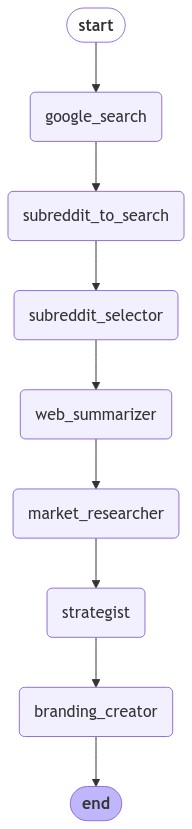

In [28]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [72]:
product = "We are an AI automation services agency named 'INFINITLY' that empowers business owners with cutting-edge AI solutions. Our services include developing AI-powered applications, robust RAG (Retrieval-Augmented Generation) chatbots, and custom AI Telegram bots, all designed to streamline operations, enhance customer interactions, and drive business growth. With our expertise, businesses can leverage advanced AI technology to stay competitive and innovative. competition website: https://tovie.ai/ai-consulting"

inputs = {"product": product}

In [ ]:
details= {
      "product_details": {
        "name": "[Startup Name]",
        "product_service": "[Product or Service]",
        "industry": "[Industry]",
        "problem_solved": "[Problem]"
        "Competition Website": "[url]"
      }
     }

inputs = {"product": product}

### Graph Build

In [ ]:
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["landing_page"])

In [73]:
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")


output = app.invoke(inputs)#, config={"configurable": {"thread_id": 42}})

#output["messages"][-1].content

genrated_branding= output['branding']

print(colored(f"Branding:", 'green'))
print(colored(f"\nMessage: {genrated_branding}", 'cyan'))


---GOOOGLE SEARCHER---
Title: Branding in the Age of AI Automation and Innovation
Link: https://www.linkedin.com/pulse/branding-age-ai-automation-innovation-endeavour-marketing-llp-9ylaf
Snippet: 1. Personalization at Scale: AI enables brands to deliver highly personalized experiences to consumers. · 2. Enhanced Customer Insights: AI- ...
---
Title: AI for customer success: Significance, applications ...
Link: https://www.leewayhertz.com/ai-for-customer-success/
Snippet: Our strategic AI/ML consulting empowers businesses to leverage artificial intelligence for improved customer engagement, enhanced support efficiency, and ...
---
Title: Ai Automation Agency
Link: https://love.marketing/ai-automation-agency/
Snippet: Predictive Analytics: We use AI to analyze data and predict future trends, customer behavior, and sales patterns to inform marketing strategies.
---
Title: Top 50+ Chatbot Companies September 2024
Link: https://www.upwork.com/agencies/chatbot-companies/?page=15
Snippet: Ou

NameError: name 'branding' is not defined

In [ ]:

print(colored(f"Landing Page:", 'green'))
print(colored(f"\nMessage: {landing_page}", 'cyan'))

Landing Page:

Message: ```
Title: Landing page for DocuAI Chatbot
- Above the fold
	- Headline
		- "Struggling to understand your legal and financial documents?"
		- "Do you wish document management was easier?"
		- "Imagine making informed decisions without document stress."
	- Subheadline
		- "DocuAI Chatbot helps small business owners like you quickly find answers in your documents."
		- "Get clear, accurate responses about your documents effortlessly."
	- Bullet points
		- "Quickly locate essential information without sifting through pages."
		- "Understand complex documents with easy-to-follow explanations."
		- "Save time and focus on what really matters for your business."
		- "Seamlessly integrates with your existing document formats."
		- "User-friendly interface designed for effortless interaction."
		- "Gain confidence in your document management process."
	- Call to action
		- "Get started now!"
		- "Find out how it works!"
		- "See if DocuAI is right for you!"
- Message f